# Malware Family Classification: BERT + CNN

> Author: Tien Ly  
> CS 271: Topics in Machine Learning - Spring 2025 at San Jose State University

This notebook implements a CNN-based malware classifier using BERT embeddings of API call sequences. Each API call sequence is tokenized and embedded using a pre-trained BERT model, and a multi-filter CNN is then applied to extract local patterns relevant to malware family classification. This notebook is the third part of the `malware-ml` series, which explores different embedding and modeling strategies for API call-based malware classification.

Note: The first notebook in the series is `malware-ml.ipynb`.

## Section 1: Data Loading

In [21]:
# %pip install numpy pandas matplotlib seaborn scikit-learn xgboost gensim transformers torch ipykernel ipywidgets

In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [2]:
def set_seed(seed_value=42):
    """ Set random seeds for reproducibility """

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [3]:
base_path = 'data_family/AllFiles_CleanLogAPI'
malware_families = os.listdir(base_path)
malware_families.sort()

print(f'Malware families: {malware_families}')

Malware families: ['adload', 'bancos', 'onlinegames', 'vbinject', 'vundo', 'winwebsec', 'zwangi']


In [4]:
# Read the dataset prepared in the previous notebook (malware1.ipynb)
malware = pd.read_pickle('malware.pkl')
display(malware)

,filename,family,api_calls,family_encoded
0,VirusShare_000e2f2b46fe9a883f550a2c493bc86e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
1,VirusShare_00e7a6c7cedd158560fdf691e2bd86c8_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
2,VirusShare_0191bf41bdbd64cc2a789824038b136f_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
3,VirusShare_019c795a6bedb2aae2392590dc35eab1_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
4,VirusShare_0239ea751e7de5ea1cb0c463e924c469_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
...,...,...,...,...
487,VirusShare_ee8abd8831806a06a85e8821db773277_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
488,VirusShare_f2b606c3319af4d2e99d308520f2b956_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
489,VirusShare_f30c6a1331242ca842337334d9d251bc_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
490,VirusShare_f316af76d837f5444d3ff1bd03b76409_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6


## Section 2: BERT Data Preparation

### 2.1 BERT

In [5]:
# Load pre-trained model tokenizer (vocabulary)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### 2.2 PyTorch Data Preparation

In [6]:
# Split the data into training, validation, and test sets (80% training, 10% validation, 10% test)
X = malware['api_calls'].tolist()
y_tensor = torch.tensor(malware['family_encoded'])

X_train, X_temp, y_train_bert_tensor, y_temp_bert_tensor = \
    train_test_split(X, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

X_val, X_test, y_val_bert_tensor, y_test_bert_tensor = \
    train_test_split(X_temp, y_temp_bert_tensor, test_size=0.5, random_state=42, stratify=y_temp_bert_tensor)

In [7]:
# Tokenize the training, validation, and test sets
X_train_bert_tensor = bert_tokenizer(X_train, return_tensors='pt', padding=True, truncation=True, return_token_type_ids=False) 
X_val_bert_tensor = bert_tokenizer(X_val, return_tensors='pt', padding=True, truncation=True, return_token_type_ids=False)
X_test_bert_tensor = bert_tokenizer(X_test, return_tensors='pt', padding=True, truncation=True, return_token_type_ids=False) 

In [8]:
# Create TensorDataset objects
bert_train_dataset = TensorDataset(X_train_bert_tensor['input_ids'], X_train_bert_tensor['attention_mask'], y_train_bert_tensor)
bert_val_dataset = TensorDataset(X_val_bert_tensor['input_ids'], X_val_bert_tensor['attention_mask'], y_val_bert_tensor)
bert_test_dataset = TensorDataset(X_test_bert_tensor['input_ids'], X_test_bert_tensor['attention_mask'], y_test_bert_tensor)

In [9]:
BATCH_SIZE = 50

# Create DataLoader objects for batch processing
bert_train_dataloader = DataLoader(bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
bert_val_dataloader = DataLoader(bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
bert_test_dataloader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Section 3: BERT-CNN Model

In [10]:
# Set computation device
if torch.cuda.is_available():       
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: NVIDIA RTX 4000 Ada Generation


### 3.1 Model Architecture

In [11]:
class BERT_CNN(nn.Module):
    def __init__(self, num_classes, bert_model_name='bert-base-uncased', num_filters=100, filter_sizes=[3, 4, 5], dropout_rate=0.5, freeze_bert=True):
        """
        Initializes the BERT-CNN model

        Args:
            num_classes (int): Number of output classes
            bert_model_name (str): Pre-trained BERT model name
            num_filters (int): Number of filters for each convolutional layer
            filter_sizes (list): List of filter sizes for convolutional layers
            dropout_rate (float): Dropout rate for regularization
            freeze_bert (bool): Whether to freeze BERT parameters during training
        """
        super().__init__()
        
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Freeze BERT parameters if specified
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        # BERT embedding dimension is 768 for bert-base-uncased
        self.embedding_dim = 768
        
        # Convolutional layers with different filter sizes
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embedding_dim,
                    out_channels=num_filters, 
                    kernel_size=fs)
            for fs in filter_sizes
        ])
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
    
    def forward(self, input_ids, attention_mask):
        """
        Forward pass through the network
        
        Args:
            input_ids (torch.Tensor): Input token IDs
            attention_mask (torch.Tensor): Attention mask for padding tokens
        """
        # Get BERT embeddings
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state # [batch_size, seq_len, hidden_size]
        
        # Apply CNN on BERT embeddings
        # Transpose for conv1d [batch_size, embedding_dim, seq_len]
        x = sequence_output.permute(0, 2, 1)
        
        # Apply convolutions
        conv_outputs = [F.relu(conv1d(x)) for conv1d in self.conv1d_list]
        
        # Apply max pooling
        pooled_outputs = [F.max_pool1d(output, output.shape[2]) for output in conv_outputs]
        
        # Concatenate the pooled outputs
        fc_input = torch.cat([output.squeeze(dim=2) for output in pooled_outputs], dim=1)
        
        # Apply dropout and classification layer
        logits = self.fc(self.dropout(fc_input))
        
        return logits

In [28]:
# Initialize the BERT-CNN model
bert_cnn = BERT_CNN(
    num_classes=len(malware_families),
    bert_model_name='bert-base-uncased',
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout_rate=0.5,
    freeze_bert=True
).to(device)
print(bert_cnn)

# Loss function and optimizer
bert_cnn_criterion = nn.CrossEntropyLoss()
bert_cnn_optimizer = optim.Adam(bert_cnn.parameters(), lr=0.01)

# Learning rate scheduler to reduce LR when training plateaus
bert_cnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(bert_cnn_optimizer, mode='min', factor=0.5, patience=10)

BERT_CNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

### 3.2 Training and Evaluation Functions

In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
  """
  Trains model for one epoch

  Args:
      model (nn.Module): The model to train
      dataloader (DataLoader): DataLoader for training data
      criterion (nn.Module): Loss function
      optimizer (torch.optim.Optimizer): Optimizer
      device (torch.device): Device to run the model on
  """
  model.train()

  running_loss = 0.0
  correct = 0
  total = 0

  for input_ids, attention_mask, labels in dataloader:
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_ids, attention_mask)

    # Compute loss
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  # Compute average loss and accuracy
  epoch_loss = running_loss / len(dataloader)
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy

In [14]:
def evaluate(model, dataloader, criterion, device):
  """
  Evaluates model performance

    Args:
        model (nn.Module): The model to evaluate
        dataloader (DataLoader): DataLoader for evaluation data
        criterion (nn.Module): Loss function
        device (torch.device): Device to run the model on
  """
  model.eval()

  running_loss = 0.0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for input_ids, attention_mask, labels in dataloader:
      input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

      outputs = model(input_ids, attention_mask)
      loss = criterion(outputs, labels)

      running_loss += loss.item()
      _, predicted = torch.max(outputs, dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # Store predictions and labels
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  epoch_loss = running_loss / len(dataloader)
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy, all_preds, all_labels

### 3.3 Model Training

In [29]:
num_epochs = 50
best_accuracy = 0.0
early_stopping_counter = 0
early_stopping_patience = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
print('Starting training...')
for epoch in range(num_epochs):
  # Train one epoch
  train_loss, train_accuracy = train_epoch(bert_cnn, bert_train_dataloader, bert_cnn_criterion, bert_cnn_optimizer, device)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # Evaluate on validation set
  val_loss, val_accuracy, _, _ = evaluate(bert_cnn, bert_val_dataloader, bert_cnn_criterion, device)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # Update learning rate
  bert_cnn_scheduler.step(val_loss)

  # Print metrics
  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'  Train loss: {train_loss:.4f}. Train accuracy: {train_accuracy:.2f}%')
  print(f'  Validation loss: {val_loss:.4f}. Validation accuracy: {val_accuracy:.2f}%')

  # Save best model
  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    torch.save(bert_cnn.state_dict(), 'best_bert_cnn_model_1.pt')
    print(f'  Saved new best model with accuracy: {best_accuracy:.2f}%')
    early_stopping_counter = 0
  else:
    early_stopping_counter += 1

  # Early stopping
  if early_stopping_counter >= early_stopping_patience:
    print(f'Early stopping triggered after {epoch+1} epochs')
    break

print(f'Training completed after {epoch+1} epochs. Best validation accuracy: {best_accuracy:.2f}%')
# Load best model for evaluation
bert_cnn.load_state_dict(torch.load('best_bert_cnn_model_1.pt'))

Starting training...


Epoch 1/50
  Train loss: 14.4150. Train accuracy: 17.81%
  Validation loss: 2.6636. Validation accuracy: 46.94%
  Saved new best model with accuracy: 46.94%
Epoch 2/50
  Train loss: 2.2041. Train accuracy: 37.40%
  Validation loss: 0.9305. Validation accuracy: 67.35%
  Saved new best model with accuracy: 67.35%
Epoch 3/50
  Train loss: 1.2913. Train accuracy: 51.91%
  Validation loss: 0.8840. Validation accuracy: 73.47%
  Saved new best model with accuracy: 73.47%
Epoch 4/50
  Train loss: 1.0983. Train accuracy: 60.81%
  Validation loss: 0.8205. Validation accuracy: 73.47%
Epoch 5/50
  Train loss: 1.0135. Train accuracy: 65.65%
  Validation loss: 0.8079. Validation accuracy: 77.55%
  Saved new best model with accuracy: 77.55%
Epoch 6/50
  Train loss: 1.0118. Train accuracy: 62.85%
  Validation loss: 0.7526. Validation accuracy: 75.51%
Epoch 7/50
  Train loss: 0.8884. Train accuracy: 65.90%
  Validation loss: 0.7007. Validation accuracy: 79.59%
  Saved new best model with accuracy: 79.5

<All keys matched successfully>

### 3.4 Evaluation and Results

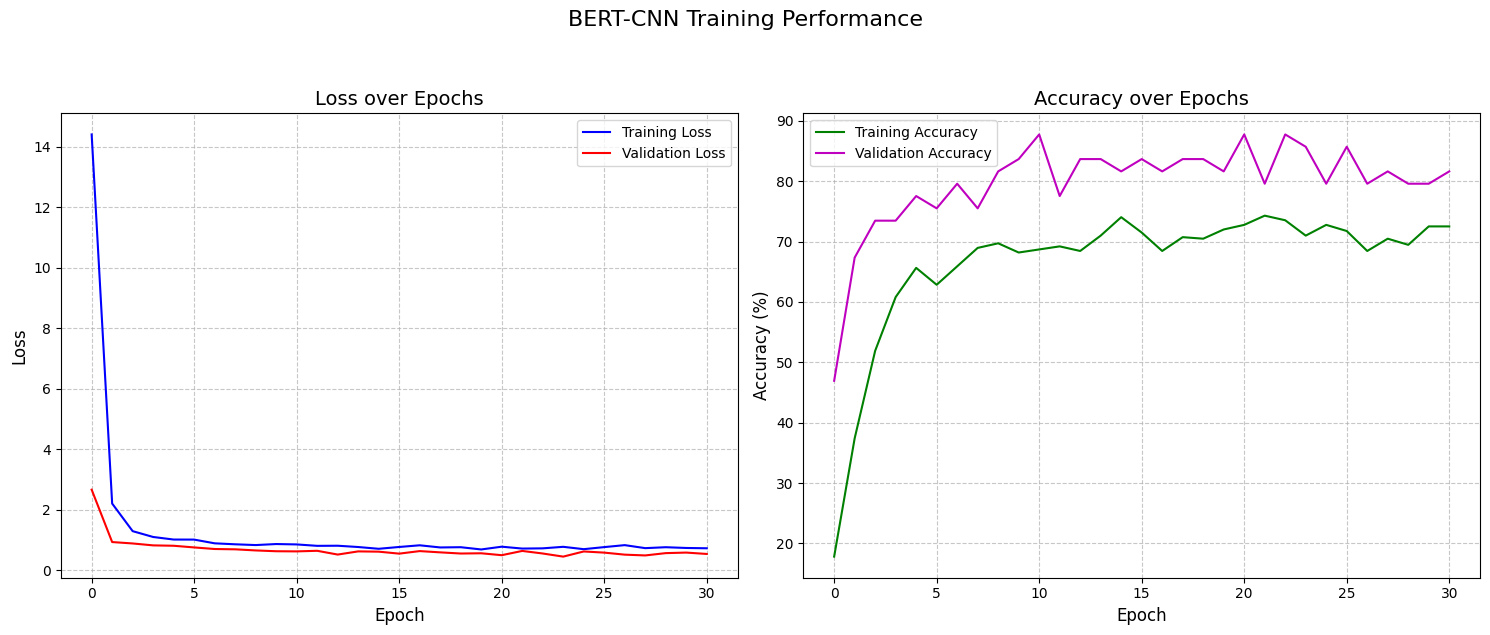

In [35]:
plt.figure(figsize=(15, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss over Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'g-', label='Training Accuracy')
plt.plot(val_accuracies, 'm-', label='Validation Accuracy')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy over Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.suptitle('BERT-CNN Training Performance', fontsize=16, y=1.05)
plt.tight_layout()

In [34]:
# Final evaluation
test_loss, test_accuracy, y_pred_bert_cnn, y_true_bert_cnn = evaluate(bert_cnn, bert_test_dataloader, bert_cnn_criterion, device)

print('BERT-CNN Classifer:')
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.2f}%")
print(classification_report(y_true_bert_cnn, y_pred_bert_cnn, target_names=malware_families))

BERT-CNN Classifer:
Test loss: 0.3806
Test accuracy: 90.00%
              precision    recall  f1-score   support

      adload       0.88      1.00      0.93         7
      bancos       0.86      0.86      0.86         7
 onlinegames       0.86      0.86      0.86         7
    vbinject       0.83      0.71      0.77         7
       vundo       0.88      0.88      0.88         8
   winwebsec       1.00      1.00      1.00         7
      zwangi       1.00      1.00      1.00         7

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50



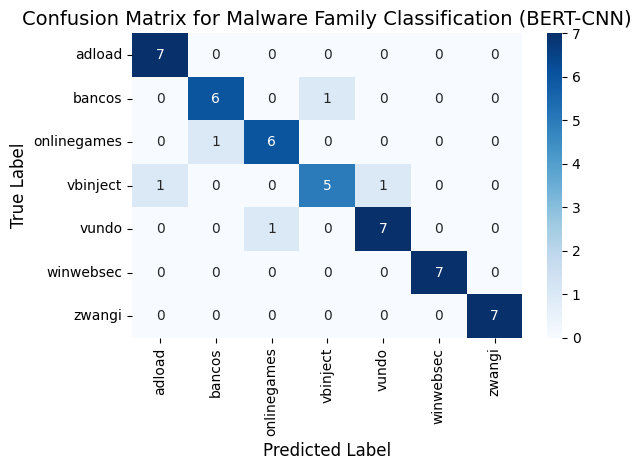

In [23]:
# Generate confusion matrix
cm_bert_cnn = confusion_matrix(y_true_bert_cnn, y_pred_bert_cnn)
cm_bert_cnn_df = pd.DataFrame(cm_bert_cnn, index=malware_families, columns=malware_families)

# Create a heatmap from the confusion matrix
sns.heatmap(cm_bert_cnn_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Malware Family Classification (BERT-CNN)', fontsize=14)
plt.tight_layout()

## Section 4: Save Results

In [ ]:
# Update accuracies DataFrame
accuracies_df = pd.read_pickle('accuracies.pkl')

new_accuracy = pd.DataFrame({
    'embedding': ['BERT'],
    'classifier': ['CNN'],
    'accuracy': [round(accuracy_score(y_true_bert_cnn, y_pred_bert_cnn), 2)]
})

accuracies_df = pd.concat([accuracies_df, new_accuracy], ignore_index=True)
accuracies_df.to_pickle('accuracies.pkl')